In [4]:
from gbdxtools import CatalogImage, Interface
import os, sys
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from scipy.misc import bytescale
import shapely
from shapely.wkt import loads
import pandas as pd

%matplotlib inline

In [2]:
image_ids = ['17669959_3',      # RE 8-29-2014, alt.id 2014-08-29T223031_RE1 (SW corner)
             '17559220_1',      # RE 8-23-2014, alt.id 2014-08-23T222157_RE5 (SW corner)
             '17511071_3',      # RE 8-14-2014, alt.id 2014-08-14T223214_RE5 (SW corner)
             '10504100112AB900' # GE 08-11-2014 (NE corner) 
            ] 

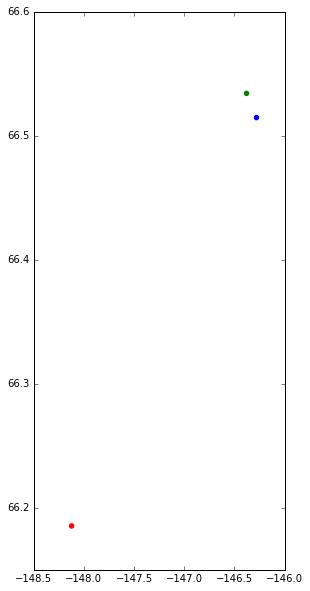

In [5]:
pts_shp = 'sample_pts/sample_pts.shp'
pts = gpd.read_file(pts_shp)

fig, ax = plt.subplots(1, figsize=(4.5,10))
pts.plot(ax=ax,  color=['Red', 'Green', 'Blue'], alpha=1, legend=True)
# ax.legend(loc='middle')
plt.show()

In [6]:
gbdx = Interface()

In [34]:
# search for other image
from shapely.geometry import box

# query = 'item_type:QB OR item_type:GE01'
# query = 'item_type:GE01'
# query = 'item_type:QB02'
query = 'item_type:WV03_VNIR OR item_type:WV02 OR item_type:QB02 OR item_type:GE01'
query = 'item_type:WV03_VNIR OR item_type:WV02'

for i,pt in enumerate(pts['geometry']):
    
    print('searching for point ', i)
    this_bbox = pt.buffer(0.003).bounds
    aoi = box(*this_bbox).wkt
    recs = gbdx.vectors.query(aoi, query, count=100)
    #print(len(recs))

    cat_ids=[]
    for r in recs:
        
        props = r['properties']
        if not props['attributes']['catalogID'] in cat_ids:
            cat_ids.append(props['attributes']['catalogID'])
            print(props['attributes']['catalogID'], 
                  props['item_date'][0:10], 
                  props['item_type'][1], 
                  props['attributes']['platformName'])

    print(len(cat_ids))
    print('')           


('searching for point ', 0)
(u'103001007F793000', u'2018-05-18', u'Acquisition', u'WORLDVIEW02')
(u'103001007DD65000', u'2018-05-15', u'Acquisition', u'WORLDVIEW02')
(u'1040010018343C00', u'2016-02-07', u'Acquisition', u'WORLDVIEW03_VNIR')
(u'10400100185B2400', u'2016-02-07', u'Acquisition', u'WORLDVIEW03_VNIR')
(u'103001004BAE5E00', u'2015-10-29', u'Acquisition', u'WORLDVIEW02')
(u'103001004C882F00', u'2015-10-29', u'Acquisition', u'WORLDVIEW02')
(u'1030010049962800', u'2015-10-17', u'Acquisition', u'WORLDVIEW02')
(u'103001004A692200', u'2015-10-25', u'Acquisition', u'WORLDVIEW02')
(u'10300100520CFE00', u'2016-02-14', u'Acquisition', u'WORLDVIEW02')
(u'10300100539AA800', u'2016-02-14', u'Acquisition', u'WORLDVIEW02')
(u'103001005298CB00', u'2016-02-08', u'Acquisition', u'WORLDVIEW02')
(u'103001004A074200', u'2015-10-17', u'Acquisition', u'WORLDVIEW02')
(u'10300100052D5300', u'2010-05-24', u'WV02', u'WORLDVIEW02')
(u'1030010006C8A500', u'2010-08-12', u'Acquisition', u'WORLDVIEW02')
(u'

In [13]:
recs[0]

{u'geometry': {u'coordinates': [[[[-146.3640399, 67.01344043],
     [-145.9846116, 67.01622184],
     [-145.9843336, 66.98513496],
     [-145.9841137, 66.95401079],
     [-145.9838601, 66.92285867],
     [-145.9836438, 66.8916689],
     [-145.9833855, 66.86045132],
     [-145.9831533, 66.82920392],
     [-145.9829698, 66.79791546],
     [-145.9827534, 66.76659735],
     [-145.9824835, 66.73524252],
     [-145.9822393, 66.70384184],
     [-145.9819612, 66.67240501],
     [-145.9816969, 66.64093814],
     [-145.981452, 66.60944866],
     [-145.9812181, 66.57793185],
     [-145.9810308, 66.5463788],
     [-145.9808374, 66.51479524],
     [-145.9805877, 66.48317553],
     [-145.9804095, 66.45151499],
     [-145.9801301, 66.41982338],
     [-145.9799319, 66.38809416],
     [-145.9797671, 66.35633407],
     [-145.9795685, 66.32452145],
     [-145.9792843, 66.29268361],
     [-145.9790216, 66.26080751],
     [-145.9789028, 66.22889178],
     [-145.9787245, 66.19694205],
     [-145.9790275, 66

In [6]:
poly = loads(aoi)
df = pd.DataFrame({'geometry': poly}, index=[0])

              


In [7]:
gdf = gpd.GeoDataFrame(df)
gdf.crs = {'init': 'epsg:4326', 'no_defs': True}
temp = gdf.to_crs(epsg=32607)

In [8]:
temp['geometry'][0].area,temp['geometry'][0].bounds

(178695.59846898908,
 (265235.5060103524, 7386862.270716549, 265558.08320051746, 7387551.704168542))

In [9]:
bnds = temp['geometry'][0].bounds
bnds[3] - bnds[1], bnds[2] - bnds[0]

(689.4334519933909, 322.5771901650587)

## search the catalog and view as data frames

In [36]:
def flatten_dict(d):
    def expand(key, value):
        if isinstance(value, dict):
            return [ (key + '.' + k, v) for k, v in flatten_dict(value).items() ]
        else:
            return [ (key, value) ]

    items = [ item for k, v in d.items() for item in expand(k, v) ]

    return dict(items)

def flatten_dict_dg(d):
    def expand(key, value):
        if isinstance(value, dict):
            return [ (key + '.' + k, v) for k, v in flatten_dict(value).items() ]
        else:
            return [ (key, value) ]

    items = [ item for k, v in d.items() for item in expand(k, v) ]
    d = dict(items)
    d['properties.item_type'] = d['properties.item_type'][-1]
    
    return d


# search for other image
from shapely.geometry import box

# query = 'item_type:QB OR item_type:GE01'
# query = 'item_type:GE01'
# query = 'item_type:QB02'
query = 'item_type:WV03_VNIR OR item_type:WV02 OR item_type:QB02 OR item_type:GE01'

pt_dfs = []
for i,pt in enumerate(pts['geometry']):
    
    print('searching for point ', i)
    this_bbox = pt.buffer(0.003).bounds
    aoi = box(*this_bbox).wkt
    recs = gbdx.vectors.query(aoi, query, count=100)
    print(len(recs))
    pt_dfs.append(pd.DataFrame([flatten_dict_dg(r) for r in recs]))


('searching for point ', 0)
46
('searching for point ', 1)
80
('searching for point ', 2)
52


In [37]:
item_type = 'properties.item_type'
pt0_df = pt_dfs[0]
pt0_sensors = pt0_df.groupby(item_type)

print(pt0_sensors)
for name, group in pt0_sensors:
    print(name)

1BProduct
GE01
QB02
WV02
WV03_VNIR


In [41]:
ls_df = list(pt0_sensors)
df_1B = ls_df[0][1]
df_qb = ls_df[1][1]
df_wv02 = ls_df[2][1]
df_wv03 = ls_df[3][1]

In [43]:
df_wv03['properties.attributes.cloudCover_int']

7     16
8     54
10     3
12     3
24    44
25    99
26    99
27     8
28    99
29    52
30    99
31    74
34     0
35     0
36     2
37    90
38     0
Name: properties.attributes.cloudCover_int, dtype: int64

In [65]:
# get ids if cloud cover is less than some number
cc_thresh=20
cat_ids_to_order = []
for data_fr in (df_qb, df_wv02, df_wv03):
    
    temp_df = data_fr.loc[data_fr['properties.attributes.cloudCover_int'] < cc_thresh]
    cat_ids_to_order += list(temp_df['properties.attributes.catalogID'].values)

In [66]:
cat_ids_to_order

[u'1050410002E87300',
 u'1050410002E87300',
 u'1050410002E0EF00',
 u'1050410002E87300',
 u'1050410003048200',
 u'101001000F9D4A00',
 u'101001000F9D4A00',
 u'101001000F9D4A00',
 u'101001000F9D4A00',
 u'101001000840ED00',
 u'10100100070E1600',
 u'1010010005A5D600',
 u'1010010005AC8A00',
 u'103001007F793000',
 u'103001007F793000',
 u'103001007F793000',
 u'103001005298CB00',
 u'10300100052D5300',
 u'10300100052D5300',
 u'10300100052D5300',
 u'1030010012785500']

In [67]:
order_flag = True
if order_flag:
    bad_id_wfs = []
    gbdx = Interface()
    for bid in cat_ids_to_order:
        tasks = []

        # Pre-Image Auto ordering task parameters
        pre_order = gbdx.Task("Auto_Ordering")
        pre_order.inputs.cat_id = bid
        pre_order.impersonation_allowed = True
        pre_order.persist = True
        pre_order.timeout = 36000
        #uc_task.inputs.pre_image_dir = pre_order.outputs.s3_location.value
        tasks += [pre_order]

        # Set up workflow save data
        workflow = gbdx.Workflow(tasks)
        workflow.savedata(pre_order.outputs.s3_location, location='mcglinchy_yukon_data/{}'.format(bid))

        # Execute workflow
        workflow.execute()

        # append to list
        bad_id_wfs.append(workflow)

In [70]:
for i,wf in enumerate(bad_id_wfs):
    print('workflow id {}, {} of {}'.format(wf.id, i+1, len(bad_id_wfs)))
    print('status: {}'.format(wf.status))
    print('')
           

workflow id 4944132640958835518, 1 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132643153150290, 2 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132645391142718, 3 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132647571587963, 4 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132649755404023, 5 of 21
status: {u'state': u'pending', u'event': u'waiting'}

workflow id 4944132652428630995, 6 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132654638746147, 7 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132659220023547, 8 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132661757720788, 9 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132664132341542, 10 of 21
status: {u'state': u'pending', u'event': u'waiting'}

workflow id 4944132666442